In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    top_k_accuracy_score,
)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv("C:\\Users\\matej\\.cache\\kagglehub\\datasets\\tobiasbueck\\multilingual-customer-support-tickets\\versions\\9\\dataset-tickets-multi-lang-4-20k.csv")  
df.head()

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [16]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subject        20000 non-null  object
 1   body           20000 non-null  object
 2   answer         19996 non-null  object
 3   type           20000 non-null  object
 4   queue          20000 non-null  object
 5   priority       20000 non-null  object
 6   language       20000 non-null  object
 7   tag_1          20000 non-null  object
 8   tag_2          19954 non-null  object
 9   tag_3          19905 non-null  object
 10  tag_4          18461 non-null  object
 11  tag_5          13091 non-null  object
 12  tag_6          7351 non-null   object
 13  tag_7          3928 non-null   object
 14  tag_8          1907 non-null   object
 15  tags_combined  20000 non-null  object
 16  text           20000 non-null  object
 17  queue_encoded  20000 non-null  int32 
dtypes: int32(1), object(17)
me

,queue_encoded
count,20000.000000
mean,5.046900
std,3.255062
min,0.000000
25%,1.000000
50%,5.000000
75%,9.000000
max,9.000000


In [4]:
# Fill and engineer text
df["subject"] = df["subject"].fillna("")
df["body"] = df["body"].fillna("")
tag_cols = [col for col in df.columns if col.startswith("tag_")]
df["tags_combined"] = df[tag_cols].fillna("").agg(" ".join, axis=1)
df["text"] = df["subject"] + " " + df["body"] + " " + df["tags_combined"]
df = df[df["queue"].notna()]

# Encode target
le = LabelEncoder()
df["queue_encoded"] = le.fit_transform(df["queue"])

# Split by language
df_en = df[df["language"] == "en"]
df_de = df[df["language"] == "de"]

# Training function with Top-2 scoring
def train_branch(df_branch, lang_label, label_encoder):
    print(f"\n=== Training SVC Model for {lang_label} ===")
    X = df_branch[["text", "priority", "type"]]
    y = df_branch["queue_encoded"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    text_transformer = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000))
    ])
    categorical_transformer = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer([
        ("text", text_transformer, "text"),
        ("cat", categorical_transformer, ["priority", "type"])
    ])

    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", SVC(C=10, kernel="rbf", class_weight=None, probability=True))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_probs = pipeline.predict_proba(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Top-2 Accuracy:", top_k_accuracy_score(y_test, y_probs, k=2))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return y_test, y_pred, y_probs, label_encoder.classes_

# Run for both languages
y_test_en, y_pred_en, y_prob_en, classes_en = train_branch(df_en, "English", le)
y_test_de, y_pred_de, y_prob_de, classes_de = train_branch(df_de, "German", le)


=== Training SVC Model for English ===
Accuracy: 0.6448637316561845
Top-2 Accuracy: 0.7689727463312369
                                 precision    recall  f1-score   support

           Billing and Payments       0.86      0.80      0.83       260
               Customer Service       0.51      0.62      0.56       372
                General Inquiry       0.80      0.35      0.49        34
                Human Resources       0.96      0.56      0.71        41
                     IT Support       0.64      0.54      0.59       278
                Product Support       0.58      0.59      0.58       447
          Returns and Exchanges       0.87      0.47      0.61       116
            Sales and Pre-Sales       0.66      0.38      0.48        66
Service Outages and Maintenance       0.78      0.57      0.66        88
              Technical Support       0.65      0.76      0.70       683

                       accuracy                           0.64      2385
                  

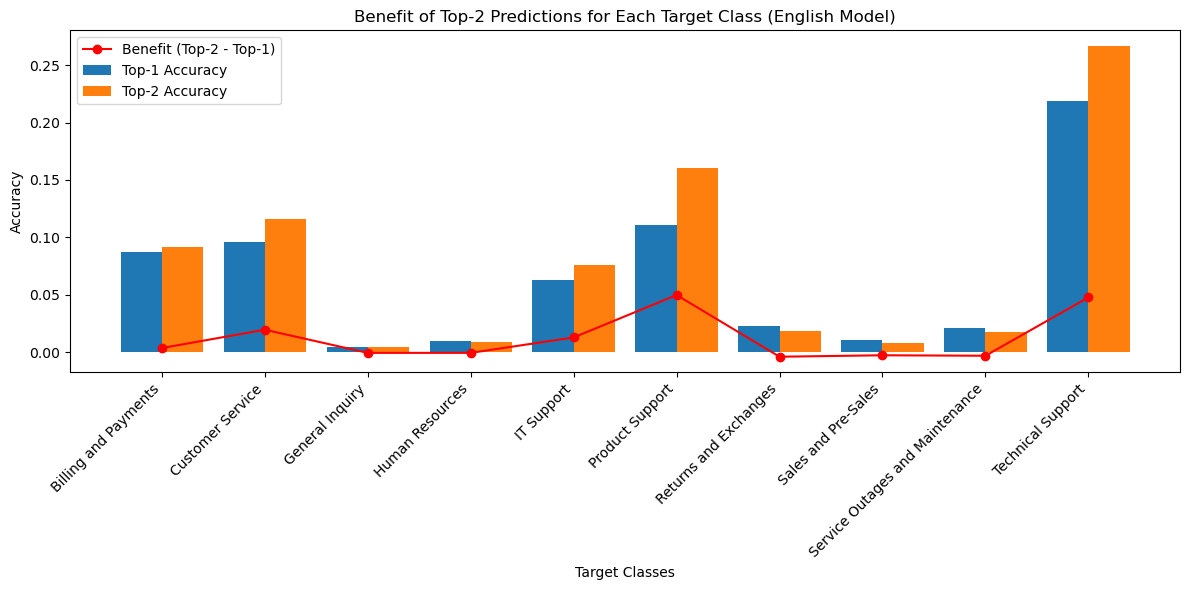

In [ ]:
# Calculate top-1 and top-2 accuracy for each class
top_1_accuracy_per_class = []
top_2_accuracy_per_class = []

for i, class_name in enumerate(classes_en):
    top_1_accuracy = np.mean((y_test_en == i) & (y_pred_en == i))
    top_2_accuracy = np.mean((y_test_en == i) & (np.argsort(y_prob_en, axis=1)[:, -2:] == i).any(axis=1))
    top_1_accuracy_per_class.append(top_1_accuracy)
    top_2_accuracy_per_class.append(top_2_accuracy)

# Calculate the benefit of top-2 predictions
benefit = np.array(top_2_accuracy_per_class) - np.array(top_1_accuracy_per_class)

# Plot for English model
plt.figure(figsize=(12, 6))
x = np.arange(len(classes_en))
plt.bar(x - 0.2, top_1_accuracy_per_class_en, width=0.4, label="Top-1 Accuracy")
plt.bar(x + 0.2, top_2_accuracy_per_class_en, width=0.4, label="Top-2 Accuracy")
plt.plot(x, benefit_en, color="red", marker="o", label="Benefit (Top-2 - Top-1)")
plt.xticks(x, classes_en, rotation=45, ha="right")
plt.xlabel("Target Classes")
plt.ylabel("Accuracy")
plt.title("Benefit of Top-2 Predictions for Each Target Class (English Model)")
plt.legend()
plt.tight_layout()
plt.show()



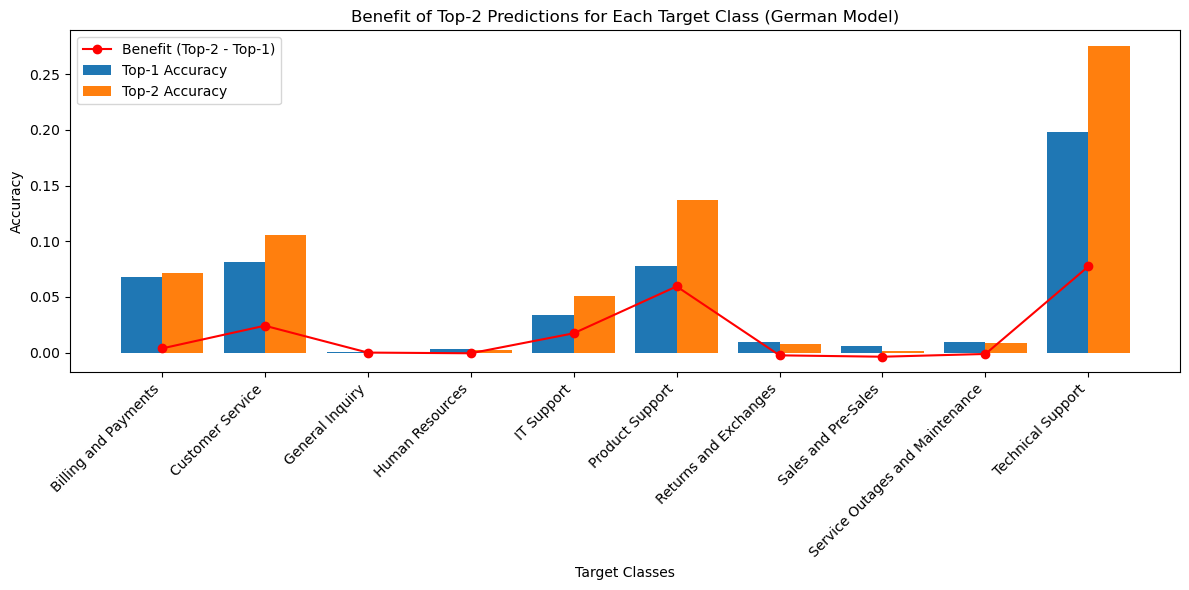

In [11]:
# Calculate top-1 and top-2 accuracy for each class for the German model
top_1_accuracy_per_class_de = []
top_2_accuracy_per_class_de = []

for i, class_name in enumerate(classes_de):
    top_1_accuracy = np.mean((y_test_de == i) & (y_pred_de == i))
    top_2_accuracy = np.mean((y_test_de == i) & (np.argsort(y_prob_de, axis=1)[:, -2:] == i).any(axis=1))
    top_1_accuracy_per_class_de.append(top_1_accuracy)
    top_2_accuracy_per_class_de.append(top_2_accuracy)

# Calculate the benefit of top-2 predictions for the German model
benefit_de = np.array(top_2_accuracy_per_class_de) - np.array(top_1_accuracy_per_class_de)

# Plot for German model
plt.figure(figsize=(12, 6))
x = np.arange(len(classes_de))
plt.bar(x - 0.2, top_1_accuracy_per_class_de, width=0.4, label="Top-1 Accuracy")
plt.bar(x + 0.2, top_2_accuracy_per_class_de, width=0.4, label="Top-2 Accuracy")
plt.plot(x, benefit_de, color="red", marker="o", label="Benefit (Top-2 - Top-1)")
plt.xticks(x, classes_de, rotation=45, ha="right")
plt.xlabel("Target Classes")
plt.ylabel("Accuracy")
plt.title("Benefit of Top-2 Predictions for Each Target Class (German Model)")
plt.legend()
plt.tight_layout()
plt.show()

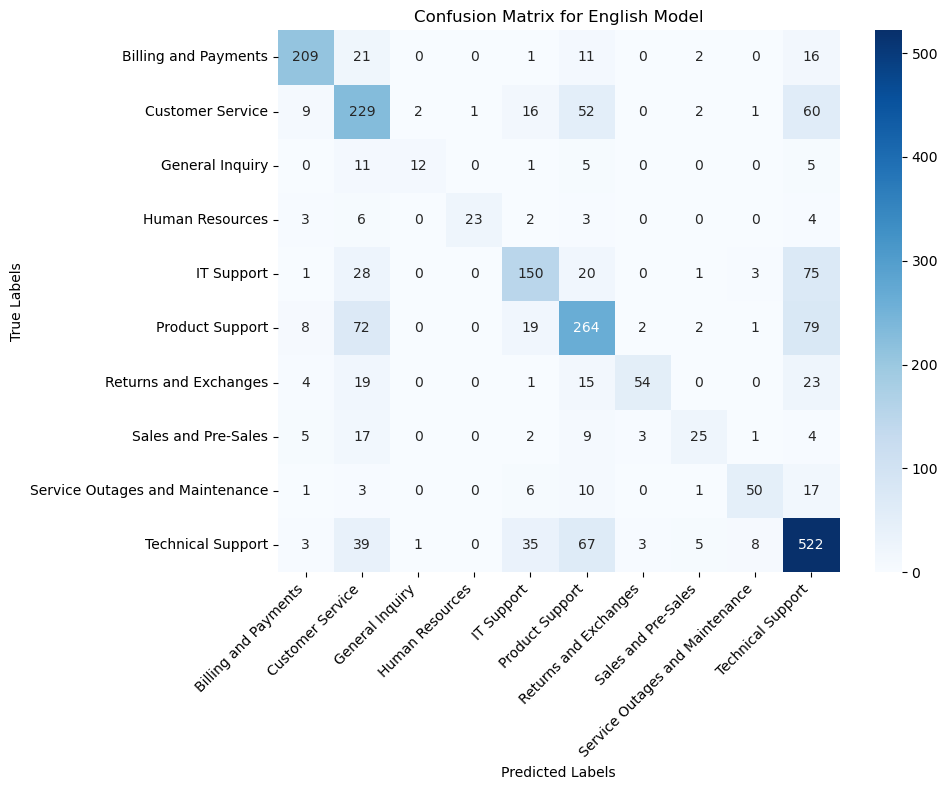

In [13]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for English model
conf_matrix_en = confusion_matrix(y_test_en, y_pred_en)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_en, annot=True, fmt='d', cmap='Blues', xticklabels=classes_en, yticklabels=classes_en)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for English Model')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

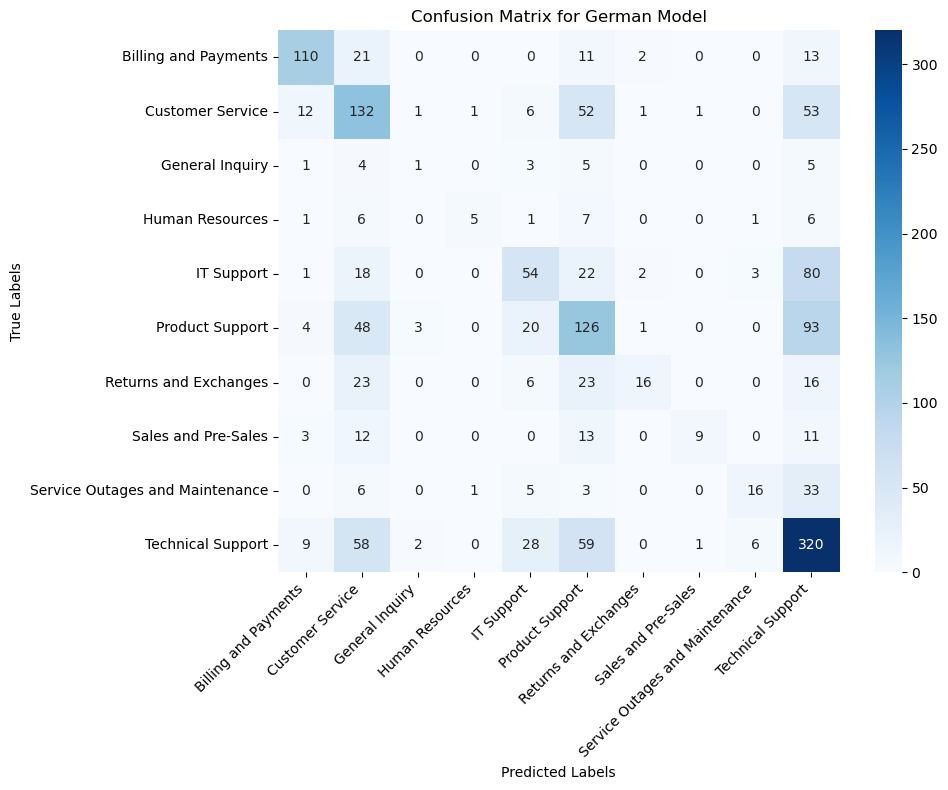

In [15]:
# Generate confusion matrix for German model
conf_matrix_de = confusion_matrix(y_test_de, y_pred_de)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_de, annot=True, fmt='d', cmap='Blues', xticklabels=classes_de, yticklabels=classes_de)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for German Model')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()